In [2]:
import pandas as pd  
from tqdm.notebook import tqdm
from moneylinefunctions import *

tqdm.pandas()

df = pd.read_csv("data/game_logs.csv")
df.drop(columns=['Unnamed: 0'], inplace=True)
df.head()

,SEASON_ID,Player_ID,Game_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,...,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE,PLAYER_NAME,SEASON
0,22023,1630230,22300837,2024-02-27,NOP @ NYK,W,28,1,4,0.25,...,3,1,0,1,0,3,13,1,Naji Marshall,2023
1,22023,1631220,22300837,2024-02-27,NOP @ NYK,W,3,0,0,0.00,...,1,0,0,0,0,0,1,1,Dereon Seabron,2023
2,22023,1631098,22300834,2024-02-27,WAS vs. GSW,L,8,0,0,0.00,...,0,0,0,0,1,0,-13,1,Johnny Davis,2023
3,22023,1631216,22300833,2024-02-27,ORL vs. BKN,W,31,3,4,0.75,...,1,2,0,1,3,9,21,1,Caleb Houstan,2023
4,22023,201567,22300842,2024-02-27,MIA @ POR,W,14,3,6,0.50,...,2,0,1,2,2,8,6,1,Kevin Love,2023


In [3]:
# Filtering out regular season games 
df["SEASON_ID"] = df["SEASON_ID"].astype(str)
df = df.loc[df["SEASON_ID"].str[:1] == "2", :]
df["SEASON_ID"] = df["SEASON_ID"].str[1:]

# Convert wins and losses to binary 
df.loc[df["WL"] == "W", "WL"] = 1
df.loc[df["WL"] == "L", "WL"] = 0

# Dropping unecessary cols 
df.drop(columns = ["SEASON", "PLAYER_NAME", "VIDEO_AVAILABLE", "MATCHUP"], inplace=True)

df.head()

,SEASON_ID,Player_ID,Game_ID,GAME_DATE,WL,MIN,FGM,FGA,FG_PCT,FG3M,...,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS
0,2023,1630230,22300837,2024-02-27,1,28,1,4,0.25,1,...,1,3,4,3,1,0,1,0,3,13
1,2023,1631220,22300837,2024-02-27,1,3,0,0,0.00,0,...,0,0,0,1,0,0,0,0,0,1
2,2023,1631098,22300834,2024-02-27,0,8,0,0,0.00,0,...,0,1,1,0,0,0,0,1,0,-13
3,2023,1631216,22300833,2024-02-27,1,31,3,4,0.75,3,...,1,5,6,1,2,0,1,3,9,21
4,2023,201567,22300842,2024-02-27,1,14,3,6,0.50,2,...,1,1,2,2,0,1,2,2,8,6


In [4]:
stat_of_interest = 'PTS'

quant_cols = [
    'MIN', 'FGM','FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT',
    'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST',
    'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PLUS_MINUS'
]

def grouping_func(group):
    # Sort in ascending order by date
    group['GAME_DATE'] = pd.to_datetime(group['GAME_DATE'])
    group.sort_values(by='GAME_DATE', ascending=True, inplace=True)
    # Create running averages for quantitative columns
    group["OBJ"] = group[stat_of_interest]

    group['Count'] = group['GAME_DATE'].expanding(1).count().shift(1).copy()
    #for col in quant_cols:
        #group[col + "_tr"] = (group[col] - group[col].iloc[0]).shift(1) / group['Count']
    
    group[quant_cols] = group[quant_cols].expanding(1).sum().shift(1).copy()
    for col in quant_cols:
        group[col] = group[col] / group['Count']

    group.drop(columns='Count', inplace=True)

    return group 

player_df = df.groupby(by=["SEASON_ID", "Player_ID"]).progress_apply(grouping_func).dropna().reset_index(drop = True)
player_df.head()

100%|██████████| 2866/2866 [00:11<00:00, 258.67it/s]


,SEASON_ID,Player_ID,Game_ID,GAME_DATE,WL,MIN,FGM,FGA,FG_PCT,FG3M,...,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,OBJ
0,2003,2544,20300018,2003-10-30,0,42.000000,12.000000,20.000000,0.600000,0.000000,...,4.00,6.000000,9.000000,4.000000,0.00,2.000000,3.000000,25.00,-9.0,21
1,2003,2544,20300038,2003-11-01,0,41.500000,10.000000,18.500000,0.535500,0.500000,...,7.00,9.000000,8.500000,2.500000,0.00,4.500000,2.000000,23.00,-6.0,8
2,2003,2544,20300057,2003-11-05,0,40.666667,7.666667,16.333333,0.440333,0.333333,...,6.00,7.333333,7.666667,2.333333,0.00,3.666667,2.333333,18.00,-11.0,7
3,2003,2544,20300068,2003-11-07,0,40.750000,6.500000,15.000000,0.398500,0.250000,...,6.75,8.250000,7.500000,2.250000,0.75,3.250000,2.000000,15.25,-9.0,23
4,2003,2544,20300078,2003-11-08,1,41.400000,6.800000,15.600000,0.407600,0.400000,...,6.40,7.600000,6.600000,1.800000,0.60,4.000000,2.000000,16.80,-8.6,17


In [5]:
df = load_data(load_new_games=True)

# Filtering out regular season games
df["SEASON"] = df["SEASON_ID"].astype(str).str[1:].astype(int)
df["SEASON_TYPE"] = df["SEASON_ID"].astype(str).str[0:1]

df = df.loc[df["SEASON_TYPE"] == '2',:]
df.drop(columns=["SEASON_TYPE"], inplace=True)

def get_matchups(df, home=True):
    if home:
        opp = df[df["MATCHUP"].str.contains("@")].copy().drop(columns = ["MATCHUP", "TEAM_NAME", "MATCHUP", "SEASON", "GAME_DATE", "PLUS_MINUS", "WL", "SEASON_ID", "TEAM_ID", "TEAM_ABBREVIATION"])
        toi = df[df["MATCHUP"].str.contains("vs")].copy().drop(columns = ["MATCHUP", "TEAM_NAME", "MATCHUP"])
        toi["Home"] = 1
    else:
        opp = df[df["MATCHUP"].str.contains("vs")].copy().drop(columns = ["MATCHUP", "TEAM_NAME", "MATCHUP", "SEASON", "GAME_DATE", "PLUS_MINUS", "WL", "SEASON_ID", "TEAM_ID", "TEAM_ABBREVIATION"])
        toi = df[df["MATCHUP"].str.contains("@")].copy().drop(columns = ["MATCHUP", "TEAM_NAME", "MATCHUP"])
        toi["Home"] = 0

    opp_cols = list(opp.columns)
    opp_cols = [col + "_opp" for col in opp_cols]
    opp.columns = opp_cols

    merged_df = pd.merge(toi, opp, left_on = "GAME_ID", right_on = "GAME_ID_opp")
    merged_df.loc[merged_df["WL"] != "W", "WL"] = 0
    merged_df.loc[merged_df["WL"] == "W", "WL"] = 1

    return merged_df


home_df = get_matchups(df, home=True)
away_df = get_matchups(df, home = False)
print("Home Win Pct: ", home_df['WL'].apply(pd.to_numeric).mean())
total_df = pd.concat((home_df, away_df)).drop(columns = ["TEAM_ABBREVIATION", "SEASON", "GAME_ID_opp"])
total_df.head()

Loading Games...


100%|██████████| 30/30 [00:29<00:00,  1.00it/s]


Loaded Games!

Home Win Pct:  0.5863849894233675


,SEASON_ID,TEAM_ID,GAME_ID,GAME_DATE,WL,MIN,PTS,FGM,FGA,FG_PCT,...,FTA_opp,FT_PCT_opp,OREB_opp,DREB_opp,REB_opp,AST_opp,STL_opp,BLK_opp,TOV_opp,PF_opp
0,22023,1610612737,22301034,2024-03-25,1,241,120,46,87,0.529,...,19,0.684,12,26,38.0,21,7,8,7,16
1,22023,1610612737,22301021,2024-03-23,1,240,132,50,90,0.556,...,14,0.714,11,28,39.0,25,3,4,13,9
2,22023,1610612737,22300925,2024-03-10,0,240,103,38,91,0.418,...,22,0.727,4,39,43.0,32,8,7,12,10
3,22023,1610612737,22300895,2024-03-06,1,241,112,43,84,0.512,...,17,0.765,10,32,42.0,27,5,4,13,16
4,22023,1610612737,22300835,2024-02-27,1,239,124,46,93,0.495,...,19,0.842,12,31,43.0,24,11,4,17,15


In [6]:
quant_cols = ['MIN', 'PTS', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PLUS_MINUS', 'MIN_opp', 'PTS_opp', 'FGM_opp', 'FGA_opp', 'FG_PCT_opp', 'FG3M_opp', 'FG3A_opp', 'FG3_PCT_opp', 'FTM_opp', 'FTA_opp', 'FT_PCT_opp', 'OREB_opp', 'DREB_opp', 'REB_opp', 'AST_opp', 'STL_opp', 'BLK_opp', 'TOV_opp', 'PF_opp']

def calculate_streaks(series):
        # Initialize streak counters
        WStreak, LStreak = 0, 0
        streaks = []
        for result in series:
            if result == 1:
                WStreak += 1
                LStreak = 0
            elif result == 0:
                LStreak += 1
                WStreak = 0
            else:
                WStreak, LStreak = 0, 0  # Reset streaks for non-W/L results
            streaks.append((WStreak, LStreak))
        return streaks

def helper_func(group):
    # Sort in ascending order by date
    group['GAME_DATE'] = pd.to_datetime(group['GAME_DATE'])
    group.sort_values(by='GAME_DATE', ascending=True, inplace=True)
    
    # Convert the group with the quantitative columns to numeric
    group[quant_cols] = group[quant_cols].apply(pd.to_numeric)
    # Calculate the game count 
    counts = group["GAME_DATE"].expanding(1).count().copy().shift(1)
    running_sum = group[quant_cols].expanding(1).sum().copy().shift(1)
    group.reset_index(inplace=True, drop = True)

    group['THIS_PM'] = group["PLUS_MINUS"].copy()

    for col in quant_cols:
        group[col] = (running_sum[col] / counts).reset_index(drop = True)

    # Calculate win/loss streaks
    streaks = calculate_streaks(group['WL'])
    group['WStreak'], group['LStreak'] = zip(*streaks)
    group[['WStreak', 'LStreak']] = group[['WStreak', 'LStreak']].shift(1)
    group[['WStreak', 'LStreak']].fillna(0, inplace=True)

    # Calculate Home win pct
    group['Home'] = group['Home'].apply(pd.to_numeric)
    home_games_mask = group['Home'] == 1
    home_wins = group['WL'][home_games_mask].expanding(1).apply(lambda x: (x == 1).sum())
    total_home_games = home_games_mask.expanding(1).sum()
    group['HomeWinPct'] = home_wins / total_home_games
    group['HomeWinPct'].fillna(method='ffill', inplace=True)  # Set away game values correctly
    group['HomeWinPct'] = group['HomeWinPct'].shift(1).fillna(0)


    return group

team_df = total_df.groupby(by = ["SEASON_ID", "TEAM_ID"]).progress_apply(helper_func).dropna()
team_df = team_df.reset_index(drop = True).drop(columns = ["SEASON_ID", "TEAM_ID", "GAME_DATE"])
team_df.head()

100%|██████████| 888/888 [00:09<00:00, 98.01it/s] 


,GAME_ID,WL,MIN,PTS,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,...,REB_opp,AST_opp,STL_opp,BLK_opp,TOV_opp,PF_opp,THIS_PM,WStreak,LStreak,HomeWinPct
0,29600017,0,241.00,81.000000,25.000000,65.000000,0.385000,4.000000,16.0,0.2500,...,40.00,26.000000,8.00,4.000000,18.000000,25.000000,-12.0,0.0,1.0,0.0
1,29600030,1,240.50,79.500000,27.000000,68.500000,0.394000,6.000000,20.0,0.2915,...,39.50,23.000000,9.50,3.000000,15.000000,23.500000,18.0,0.0,2.0,0.0
2,29600040,1,240.00,84.333333,28.666667,70.333333,0.406667,7.666667,19.0,0.4100,...,41.00,20.333333,9.00,4.333333,18.666667,23.666667,22.0,1.0,0.0,0.0
3,29600051,1,240.75,92.500000,32.250000,73.000000,0.437750,9.750000,21.5,0.4455,...,40.25,21.500000,9.25,4.000000,19.250000,23.500000,4.0,2.0,0.0,0.0
4,29600072,0,240.60,92.200000,32.200000,73.200000,0.436600,8.600000,20.8,0.4008,...,40.40,21.600000,8.60,3.800000,18.600000,24.400000,-7.0,3.0,0.0,0.0


In [7]:
opp_total_df = team_df.copy()
opp_total_df.loc[opp_total_df["WL"] == 1, "WL"] = -1
opp_total_df.loc[opp_total_df["WL"] == 0, "WL"] = 1
opp_total_df.loc[opp_total_df["WL"] == -1, "WL"] = 0
opp_total_df.head()

,GAME_ID,WL,MIN,PTS,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,...,REB_opp,AST_opp,STL_opp,BLK_opp,TOV_opp,PF_opp,THIS_PM,WStreak,LStreak,HomeWinPct
0,29600017,1,241.00,81.000000,25.000000,65.000000,0.385000,4.000000,16.0,0.2500,...,40.00,26.000000,8.00,4.000000,18.000000,25.000000,-12.0,0.0,1.0,0.0
1,29600030,0,240.50,79.500000,27.000000,68.500000,0.394000,6.000000,20.0,0.2915,...,39.50,23.000000,9.50,3.000000,15.000000,23.500000,18.0,0.0,2.0,0.0
2,29600040,0,240.00,84.333333,28.666667,70.333333,0.406667,7.666667,19.0,0.4100,...,41.00,20.333333,9.00,4.333333,18.666667,23.666667,22.0,1.0,0.0,0.0
3,29600051,0,240.75,92.500000,32.250000,73.000000,0.437750,9.750000,21.5,0.4455,...,40.25,21.500000,9.25,4.000000,19.250000,23.500000,4.0,2.0,0.0,0.0
4,29600072,1,240.60,92.200000,32.200000,73.200000,0.436600,8.600000,20.8,0.4008,...,40.40,21.600000,8.60,3.800000,18.600000,24.400000,-7.0,3.0,0.0,0.0


In [8]:
total_df = pd.merge(left=player_df, right=team_df, left_on=["Game_ID", "WL"], right_on=["GAME_ID", "WL"], how='left').dropna()
total_df = pd.merge(left=total_df, right=opp_total_df, left_on=["Game_ID", "WL"], right_on=["GAME_ID", "WL"], how='left').dropna()
print(len(total_df))
total_df.head()

153642


,SEASON_ID,Player_ID,Game_ID,GAME_DATE,WL,MIN_x,FGM_x,FGA_x,FG_PCT_x,FG3M_x,...,REB_opp_y,AST_opp_y,STL_opp_y,BLK_opp_y,TOV_opp_y,PF_opp_y,THIS_PM_y,WStreak_y,LStreak_y,HomeWinPct_y
0,2003,2544,20300018,2003-10-30,0,42.000000,12.000000,20.000000,0.600000,0.000000,...,38.0,20.0,8.0,11.00,20.00,24.0,9.0,0.0,1.0,0.000000
1,2003,2544,20300038,2003-11-01,0,41.500000,10.000000,18.500000,0.535500,0.500000,...,29.0,25.0,9.0,5.00,12.00,20.0,19.0,0.0,1.0,0.000000
2,2003,2544,20300057,2003-11-05,0,40.666667,7.666667,16.333333,0.440333,0.333333,...,48.5,20.0,12.5,7.75,17.25,26.5,4.0,0.0,1.0,1.000000
3,2003,2544,20300068,2003-11-07,0,40.750000,6.500000,15.000000,0.398500,0.250000,...,43.0,18.2,9.0,8.80,19.40,20.2,1.0,3.0,0.0,0.500000
4,2003,2544,20300078,2003-11-08,1,41.400000,6.800000,15.600000,0.407600,0.400000,...,43.8,20.4,9.2,5.60,15.80,18.4,-13.0,2.0,0.0,0.666667


In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 

X = total_df.drop(columns = ["SEASON_ID", "Player_ID", "Game_ID", "GAME_DATE", "WL"])
Y = X["OBJ"]
X.drop(columns = ["OBJ"], inplace = True)

Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.20, random_state = 420)

Xscaler = StandardScaler()
Yscaler = StandardScaler()

Xtrain = Xscaler.fit_transform(Xtrain)
Xtest = Xscaler.transform(Xtest)

In [13]:
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor

model = MLPRegressor((30), activation='relu', alpha=0e-1, max_iter = 750, tol=1e-6, verbose=True, learning_rate='adaptive', warm_start=True)
#model = RandomForestRegressor(verbose=True, n_jobs=-1)
model.fit(Xtrain, Ytrain)

Iteration 1, loss = 34.79746226
Iteration 2, loss = 21.37927543
Iteration 3, loss = 20.63632754
Iteration 4, loss = 20.21385181
Iteration 5, loss = 19.89905884
Iteration 6, loss = 19.65810756
Iteration 7, loss = 19.48730651
Iteration 8, loss = 19.35774061
Iteration 9, loss = 19.25752883
Iteration 10, loss = 19.17613994
Iteration 11, loss = 19.10384909
Iteration 12, loss = 19.05177585
Iteration 13, loss = 19.01009430
Iteration 14, loss = 18.96855903
Iteration 15, loss = 18.94139164
Iteration 16, loss = 18.90787858
Iteration 17, loss = 18.86466818
Iteration 18, loss = 18.85098857
Iteration 19, loss = 18.83445605
Iteration 20, loss = 18.81035210
Iteration 21, loss = 18.78605202
Iteration 22, loss = 18.76705088
Iteration 23, loss = 18.75300506
Iteration 24, loss = 18.74251558
Iteration 25, loss = 18.72775075
Iteration 26, loss = 18.71005635
Iteration 27, loss = 18.70744166
Iteration 28, loss = 18.70267668
Iteration 29, loss = 18.68078894
Iteration 30, loss = 18.67688102
Iteration 31, loss 

MLPRegressor(alpha=0.0, hidden_layer_sizes=30, learning_rate='adaptive',
             max_iter=750, tol=1e-06, verbose=True, warm_start=True)

In [11]:
from sklearn.metrics import mean_absolute_error

print("Train MSE: %.3f" % (mean_absolute_error(Ytrain, model.predict(Xtrain))))
print("Test MSE:  %.3f" % (mean_absolute_error(Ytest, model.predict(Xtest))))

Train MSE: 4.689
Test MSE:  4.762


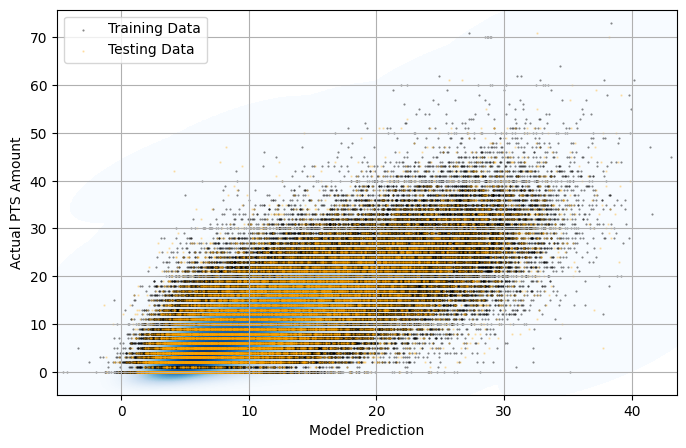

In [15]:
import matplotlib.pyplot as plt 
from sklearn.linear_model import LinearRegression, Lasso

lr = LinearRegression()
lr.fit(model.predict(Xtrain).reshape(-1,1), Ytrain)
x = np.array([min(model.predict(Xtrain)), max(model.predict(Xtrain))])
y = lr.predict(x.reshape(-1,1))

data = np.hstack((model.predict(Xtest).reshape(-1,1), Ytest.to_numpy().reshape(-1,1)))
df = pd.DataFrame(data, columns=['X', 'Y'])


plt.figure(figsize=(8,5))
sns.kdeplot(data=df, x="X", y="Y", fill=True, thresh=0, levels=100, cmap="Blues", bw_adjust=1.0)
plt.scatter(model.predict(Xtrain), Ytrain, s=0.25, label = "Training Data", c='black', alpha=0.5)
plt.scatter(model.predict(Xtest), Ytest, s=0.5, label = "Testing Data", c='orange', alpha=0.25)
#plt.plot(x,y, color='red', linestyle='--', linewidth=2, label='Line of Best Fit')
plt.grid()
plt.xlabel("Model Prediction")
plt.ylabel("Actual " + stat_of_interest + " Amount")
plt.legend()

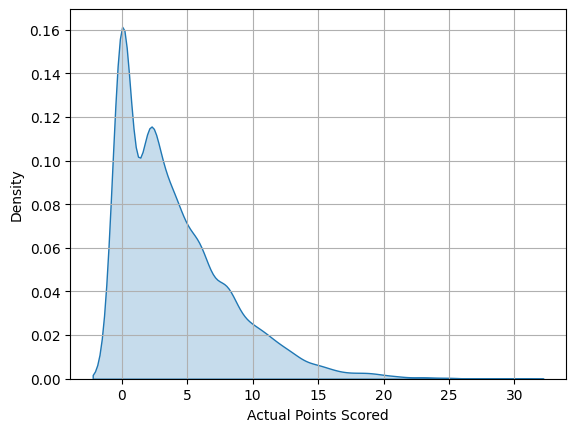

In [22]:
Yhat_train = np.round(model.predict(Xtrain))

Ytrain_spec = Ytrain[Yhat_train == 4]

sns.kdeplot(Ytrain_spec, fill=True)
plt.xlabel("Actual Points Scored")
plt.grid()